In [1]:
%matplotlib inline
import bcolz
from keras.layers import Input, Convolution2D, BatchNormalization, Activation, merge, Lambda
import keras
import keras.backend as K
from keras.models import Model
import numpy as np
from vgg16 import VGG16
from keras_tqdm import TQDMNotebookCallback
import matplotlib.pyplot as plt 

Using TensorFlow backend.


In [2]:
dpath = '/run/media/backman/yay/imagenet/'

In [3]:
arr_lr = bcolz.open(dpath + 'trn_resized_72.bc')[:5000]
arr_hr = bcolz.open(dpath + 'trn_resized_288.bc')[:5000]

In [4]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

In [40]:
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [5]:
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Convolution2D(filters, size, size, subsample=stride, border_mode=mode)(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x) if act else x

In [6]:
def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return merge([x, ip], mode='sum')

In [7]:
def deconv_block(x, filters, size, shape, stride=(2,2)):
    x = Deconvolution2D(filters, size, size, subsample=stride, 
        border_mode='same', output_shape=(None,)+shape)(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

In [8]:
def up_block(x, filters, size):
    x = keras.layers.UpSampling2D()(x)
    x = Convolution2D(filters, size, size, border_mode='same')(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

In [9]:
inp=Input(arr_lr.shape[1:])
x=conv_block(inp, 64, 9, (1,1))
for i in range(4): x=res_block(x)
x=up_block(x, 64, 3)
x=up_block(x, 64, 3)
x=Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
outp=Lambda(lambda x: (x+1)*127.5)(x)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (9, 9), strides=(1, 1), padding="same")`
  
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), strides=(1, 1), padding="same")`
  
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  after removing the cwd from sys.path.
/usr/lib/python3.6/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
  This is

In [10]:
vgg_l = Lambda(preproc)
outp_l = vgg_l(outp)

In [11]:
out_shape = arr_hr.shape[1:]

In [12]:
vgg_inp = Input(out_shape)

In [13]:
vgg = VGG16(include_top=False, input_tensor=vgg_l(vgg_inp))
for l in vgg.layers: l.trainable=False

/home/backman/mlSandbox/vgg16.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv1", padding="same")`
  x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(img_input)
/home/backman/mlSandbox/vgg16.py:43: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv2", padding="same")`
  x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(x)
/home/backman/mlSandbox/vgg16.py:47: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="block2_conv1", padding="same")`
  x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1')(x)
/home/backman/mlSandbox/vgg16.py:48: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="block2_conv2", padding="same")`
  x = Convolution2

In [14]:
vgg_content = Model(vgg_inp, vgg.get_layer('block2_conv2').output)
vgg1 = vgg_content(vgg_inp)
vgg2 = vgg_content(outp_l)

In [15]:
loss = Lambda(lambda x: K.sqrt(K.mean((x[0]-x[1])**2, (1,2))))([vgg1, vgg2])

In [16]:
m_final = Model([inp, vgg_inp], loss)
targ = np.zeros((arr_hr.shape[0], 128))

In [17]:
m_final.compile('adam','mse')

In [18]:
params = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}

In [19]:
m_final.fit([arr_lr, arr_hr], targ, 2, 2, **params)

HBox(children=(IntProgress(value=0, description='Training', max=2), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=5000), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=5000), HTML(value='')))

In [20]:
K.set_value(m_final.optimizer.lr, 1e-4)
m_final.fit([arr_lr, arr_hr], targ, 4, 1, **params)

HBox(children=(IntProgress(value=0, description='Training', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=5000), HTML(value='')))

In [21]:
top_model = Model(inp, outp)


In [34]:
p = top_model.predict(arr_lr[0:1])


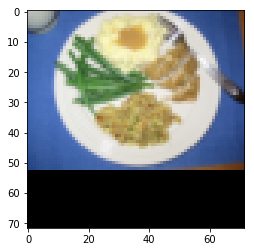

In [30]:
plt.imshow(arr_lr[0].astype('uint8'));


In [43]:
plt.imshow(p[0].astype('uint8'));


IndexError: index 10 is out of bounds for axis 0 with size 1

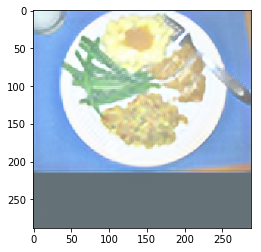

In [58]:
im = p[0]
im = im
im = im[:, :, ::-1]
plt.imshow(im.astype('uint8'))